In [138]:
from custom_dataloader import import_data_loader
import custom_dataloader
from custom_model import retina_fpn_swin_l
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
import torch.nn as nn
from torchvision.ops import focal_loss
import torch
import matplotlib.pyplot as plt
import numpy as np 
import cv2

In [2]:
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
transformer = A.Compose([
    A.Resize(512, 512),
    A.Flip(),
    A.OneOf([
        A.Rotate(limit=(0, 90), p=0.7),
        A.Compose([
            A.HorizontalFlip(always_apply=True),
            A.Rotate(limit=(-90, 0), p=0.7)
        ])
    ], p=0.7),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=(
            0, 0.2), contrast_limit=(0, 0.3), p=0.7),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.7),
        A.Sharpen(alpha=(0.2, 0.8), lightness=(0.5, 1.0), p=0.7)
    ], p=0.7),
    A.Normalize(mean=mean,std=std,
                max_pixel_value=255.0),
    ToTensorV2()
], bbox_params=A.BboxParams(format='coco', label_fields=['class_ids']))

In [137]:
val_transformer = A.Compose([
        A.Resize(height=512, width=512),
         A.Normalize(mean=mean,std=std,
                max_pixel_value=255.0),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['class_ids']),
)

In [144]:
dataset = custom_dataloader.CustomDataset('../info/test.json' , transformer = val_transformer)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [156]:
from torch.utils.data import DataLoader
val_loader = DataLoader(dataset = dataset , batch_size = 8)

In [157]:
class CustomDataset(data.Dataset):
    def __init__(self, data_dir, transformer=None):
        super(CustomDataset, self).__init__()
        self.coco = COCO(data_dir)
        self.img_idx_list = self.coco.getImgIds()
        self.transformer = transformer
        ori_shape = (596, 784, 3)
        pad_shape = (512, 512, 3)
        img_shape = (512, 512, 3)
        xy_ratio = np.array(
            list(y/x for x, y in zip(ori_shape, img_shape))[:2], dtype=np.float32)[::-1]
        scale_factor = np.tile(xy_ratio, 2)
        self.img_info = {'filename': '../dataset/', 'ori_filename': '', 'ori_shape': ori_shape,
                         'img_shape': img_shape, 'pad_shape': pad_shape, 'scale_factor': scale_factor, 'flip': False,
                         'flip_direction': None,
                         'img_norm_cfg': {'mean': np.array([46.84, 46.84, 46.84], dtype=np.float32),
                                          'std': np.array([48.73, 48.73, 48.73], dtype=np.float32)},
                         'to_rgb': True}

    def __len__(self):
        return len(self.img_idx_list)

    def __getitem__(self, idx):

        img_meta, image = self.get_image(idx)
        bboxes, class_ids = self.get_label(idx)

        if self.transformer:
            transformed_data = self.transformer(
                image=image, bboxes=bboxes, class_ids=class_ids)
            image = transformed_data['image']
            bboxes = np.array(coco_cv2(transformed_data['bboxes']))
            class_ids = np.array(transformed_data['class_ids'])

            if len(class_ids) == 0:
                bboxes = torch.empty(0, 4, dtype=torch.float32)
                class_ids = torch.empty(0, 1, dtype=torch.long)

        return img_meta, image, bboxes, class_ids

    def get_image(self, idx):
        img_meta = copy.deepcopy(self.img_info)
        img_info = self.coco.loadImgs(ids=idx)[0]
        filename = img_info['file_name']
        image_path = os.path.join('../dataset', filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_meta['filename'] += filename
        img_meta['ori_filename'] = filename
        return img_meta, image

    def get_label(self, idx):
        ann_ids = self.coco.getAnnIds(imgIds=idx)
        anns = self.coco.loadAnns(ann_ids)
        bboxes = np.array([ann['bbox'] for ann in anns])
        class_ids = np.array([ann['category_id'] for ann in anns])

        return bboxes, class_ids
for i in val_loader:
    pass

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/user304/anaconda3/envs/openmmlab/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3771018/1045950065.py", line 1, in <module>
    for i in val_loader:
  File "/home/user304/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 681, in __next__
    data = self._next_data()
  File "/home/user304/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 721, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/home/user304/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/user304/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listco

In [ ]:
from torch import dataloader

In [3]:
dataloader = import_data_loader('../info/train.json' , transformer = transformer)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
model = retina_fpn_swin_l()

In [5]:
inputs = next(iter(dataloader))
img_metas , images , bboxes , labels = inputs

In [6]:
bboxes

[tensor([], size=(0, 4)),
 tensor([[174.5590, 217.8167, 310.8747, 351.3637]]),
 tensor([], size=(0, 4)),
 tensor([], size=(0, 4)),
 tensor([], size=(0, 4)),
 tensor([[205.0612, 175.2483, 303.0204, 271.4631]]),
 tensor([[207.6735, 172.6711, 306.2857, 270.6040]]),
 tensor([], size=(0, 4))]

In [7]:
de_std = tuple(std * 255 for std in std)
de_mean = tuple(mean * 255 for mean in mean)

In [8]:
image = images[1].permute(1,2,0)
img = ((image *  torch.tensor(de_std)) + torch.tensor(de_mean)).int()

In [9]:
img = img.numpy()

In [10]:
optimizer = optim.AdamW(model.parameters(), 
                        lr=0.0001 / 8,
                        betas=(0.9, 0.999),
                        weight_decay=0.05,
                        )
model = model.cuda()

In [22]:
model.load_state_dict(torch.load('./test3.pth'))

<All keys matched successfully>

In [23]:
epochs = 50
cls_losses = 0
bbox_losses = 0
total_losses = 0
for epoch in range(epochs):
    for i, (img_metas , images , bboxes , labels) in enumerate(dataloader):
        images = images.cuda()
        model.train()

        bboxes = [bbox.cuda() for bbox in bboxes]
        labels = [label.type(torch.long).cuda() for label in labels]
        outputs = model(images)
        losses = model.bbox_head.loss(
            cls_scores = outputs[0],
            bbox_preds = outputs[1],
            gt_bboxes = bboxes , 
            gt_labels = labels , 
            img_metas = img_metas
        )

        loss_cls_total = losses['loss_cls'][0] + losses['loss_cls'][1] + losses['loss_cls'][2]
        loss_bbox_total = losses['loss_bbox'][0] + losses['loss_bbox'][1] + losses['loss_bbox'][2]
        total_loss = loss_cls_total + loss_bbox_total
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        cls_losses += loss_cls_total
        bbox_losses += loss_bbox_total
        total_losses += total_loss
        if i % 100 ==0 and i > 0:
            print(f'[{i} / {len(dataloader)}]')
            print(f'step : {i}\nloss_bbox : {bbox_losses / 100}  loss_cls_total : {cls_losses /100}  total_loss : {total_losses / 100}')
            cls_losses = 0
            bbox_losses = 0
            total_losses = 0
    
    print(f'epoch : {epoch}')
    print('-' * 30)

KeyboardInterrupt: 

In [13]:
# torch.save(model.state_dict(), './test2.pth')

In [24]:
outputs[1][2].min()

tensor(-1.0783, device='cuda:0', grad_fn=<MinBackward1>)

In [25]:
outputs[0][0].min()

tensor(-63.1093, device='cuda:0', grad_fn=<MinBackward1>)

In [26]:
losses = model.bbox_head.loss(
    cls_scores = outputs[0],
    bbox_preds = outputs[1],
    gt_bboxes = bboxes , 
    gt_labels = labels , 
    img_metas = img_metas
)
losses

{'loss_cls': [tensor(0.0369, device='cuda:0', grad_fn=<MulBackward0>),
  tensor(0.0164, device='cuda:0', grad_fn=<MulBackward0>),
  tensor(0.0319, device='cuda:0', grad_fn=<MulBackward0>)],
 'loss_bbox': [tensor(0.0602, device='cuda:0', grad_fn=<MulBackward0>),
  tensor(0.0403, device='cuda:0', grad_fn=<MulBackward0>),
  tensor(0.0669, device='cuda:0', grad_fn=<MulBackward0>)]}

In [27]:
outputs[0][2].max()

tensor(0.9071, device='cuda:0', grad_fn=<MaxBackward1>)

In [28]:
labels

[tensor([2], device='cuda:0'),
 tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64),
 tensor([2], device='cuda:0'),
 tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64),
 tensor([1], device='cuda:0'),
 tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64),
 tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64),
 tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)]

In [97]:
bboxes = model.bbox_head.get_bboxes(
        cls_scores = outputs[0],
        bbox_preds = outputs[1],
        img_metas = img_metas
    )

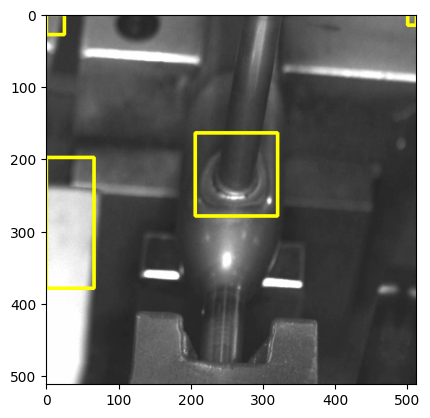

In [123]:
bbox_preds = bboxes[0][0].cpu().int().numpy()
image = images[0].permute(1,2,0).cpu()
img = ((image *  torch.tensor(de_std)) + torch.tensor(de_mean)).int()
img = img.numpy().astype(np.uint8).copy()
for i in range(len(bbox_preds)):
    cv2.rectangle(img , pt1 =bbox_preds[i,:2]  , pt2 = bbox_preds[i,2:-1], color = (255,255,0), thickness = 3)
plt.imshow(img)

In [133]:
isinstance(img ,np.ndarray)

True

In [135]:
type(img)

numpy.ndarray

In [88]:
bbox_preds[i,:2] ,bbox_preds[i,2:-1]

(array([320, 320], dtype=int32), array([320, 279], dtype=int32))

In [ ]:
torch.save(model.state_dict(), './test2.pth')

<All keys matched successfully>

In [ ]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib as mpl
import cv2
import json
from ipywidgets import interact
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
from mmdet import core
import torch
import warnings
warnings.filterwarnings('ignore')


class OD_visual:
    def __init__(self,img ,coco_gt_path, coco_pred_path=None):
        '''
        coco_gt_path (str) :
        coco_pred_path (str) :
        '''
        if isinstance(img, np.ndarray):
            self.img = img
        elif isinstance(img, str):
            if os.path.splitext(img)[1] == '.json':
        self.coco_gt = COCO(coco_gt_path)

        if coco_pred_path:
            self.coco_pred = self.coco_gt.loadRes(coco_pred_path)
        else:
            self.coco_pred = None
        # {img_name : imgId}
        self.img_name_to_id = {os.path.basename(label_info['file_name']).split('.jpg')[0]: label_info['id']
                               for label_info in self.coco_gt.loadImgs(self.coco_gt.getImgIds())}

        # {imgId : img_name}
        self.imgId_to_name = {v: k for k, v in self.img_name_to_id.items()}

        # {catId : cat_name}
        self.cat_name_to_id = {cat_info['name']: cat_info['id']
                               for cat_info in self.coco_gt.loadCats(self.coco_gt.getCatIds())}

        # {cat_name : catId}
        self.catId_to_name = {v: k for k, v in self.cat_name_to_id.items()}

    def label_to_img_path(self, data_path):
        data_path = data_path.replace('label', 'defect').replace('json', 'jpg')
        return data_path



    def widget(self, conf=None, catIds=None, areaRng=None):
        pass
